In [5]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import os

file_path = os.getenv("HOME")+"/aiffel/translator_seq2seq/data/fra.txt"
lines = pd.read_csv(file_path, names=["eng", "fra", "cc"], sep="\t")
print("전체 샘플의 수 :",len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 217975


,eng,fra,cc
153292,We ate a nice meal and drank wine.,Nous avons mangé un bon repas et avons bu du vin.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
42792,Tom loves chocolate.,Tom adore le chocolat.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
132373,The computer is in the library.,L'ordinateur est à la bibliothèque.,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
109611,Tom's parents weren't happy.,Les parents de Thomas n'étaient pas contents.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
207946,It was a fine day and there were no clouds in ...,C'était une belle journée et il n'y avait pas ...,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [6]:
num_samples = 33000

lines = lines[['eng', 'fra']][:num_samples] # 3.3만개 샘플 사용
lines.sample(5)

,eng,fra
31798,He went by bicycle.,Il y est allé en bicyclette.
30880,Breakfast is ready.,Le petit-déjeuner est prêt.
5275,I want a job.,Je veux un boulot.
5122,I handled it.,Je m'en suis sortie.
10503,Get off my car.,Descendez de ma voiture.


### Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)

In [7]:
import re
import unicodedata
# def text_pre_proc_ex(text):
#     text = text.strip()    ## strip() : 인자는 제거할 문자 지정. 지정 하지 않은 기본값은 문자열의 선행 후행 공백 제거
#     text = re.sub(r"[^-,.?!A-zÀ-ú\s]", "", text)    ## 영문자, 구두점과 공백을 제외하고 모두 제거
#     text = text.strip()
#     text = re.sub(r"^ +", "", text)    ## 1칸 초과하는 공백 제거 (첫번째 공백은 유지, 이어서 두번째 부터 공백 나타나면 제거)
#     text = text.strip()
#     return text

def to_ascii(s):
    # 프랑스어 악센트(accent) 삭제
    # 예시 : 'déjà diné' -> deja dine
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sent):
    # 악센트 제거 함수 호출
    sent = to_ascii(sent.lower())

    # 단어와 구두점 사이에 공백 추가.
    # ex) "I am a student." => "I am a student ."
    sent = re.sub(r"([?.!,¿])", r" \1", sent)

    # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환.
    sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

    # 소문자로 변경
    sent = sent.lower()

    # 다수 개의 공백을 하나의 공백으로 치환
    sent = re.sub(r"\s+", " ", sent)
    
    return sent

In [8]:
eng_sent = u"Have you had dinner?"
fra_sent = u"Avez-vous déjà diné?"

print("전처리 전 영어 문장 :", eng_sent)
print("전처리 후 영어 문장 :",preprocess_sentence(eng_sent))
print("전처리 전 프랑스어 문장 :", fra_sent)
print("전처리 후 프랑스어 문장 :", preprocess_sentence(fra_sent))

전처리 전 영어 문장 : Have you had dinner?
전처리 후 영어 문장 : have you had dinner ?
전처리 전 프랑스어 문장 : Avez-vous déjà diné?
전처리 후 프랑스어 문장 : avez vous deja dine ?


### Step 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.

In [9]:
def load_preprocessed_data():

    encoder_input, decoder_input, decoder_target = [], [], []

    with open(file_path, "r") as lines:
    
        for i, line in enumerate(lines):
            # source 데이터와 target 데이터 분리
            src_line, tar_line, _ = line.strip().split("\t")

            # source 데이터 전처리
            src_line = [w for w in preprocess_sentence(src_line).split()]

            # target 데이터 전처리
            tar_line = preprocess_sentence(tar_line)
            tar_line_in = [w for w in ("<sos> " + tar_line).split()]
            tar_line_out = [w for w in (tar_line + " <eos>").split()]

            encoder_input.append(src_line)
            decoder_input.append(tar_line_in)
            decoder_target.append(tar_line_out)

            if i == num_samples - 1:
                break

    return encoder_input, decoder_input, decoder_target

In [10]:
sents_eng_in, sents_fra_in, sents_fra_out = load_preprocessed_data()

print("인코더의 입력1 :",sents_eng_in[:3])
print()
print("디코더의 입력1 :",sents_fra_in[:3])
print()
print("디코더의 라벨1 :",sents_fra_out[:3])
print()
print()
print("인코더의 입력2 :",sents_eng_in[-3:])
print()
print("디코더의 입력2 :",sents_fra_in[-3:])
print()
print("디코더의 라벨2 :",sents_fra_out[-3:])

인코더의 입력1 : [['go', '.'], ['go', '.'], ['go', '.']]

디코더의 입력1 : [['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'en', 'route', '!']]

디코더의 라벨1 : [['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['en', 'route', '!', '<eos>']]


인코더의 입력2 : [['i', 'want', 'to', 'see', 'that', '.'], ['i', 'want', 'to', 'see', 'them', '.'], ['i', 'want', 'to', 'see', 'this', '.']]

디코더의 입력2 : [['<sos>', 'je', 'veux', 'voir', 'ca', '.'], ['<sos>', 'je', 'veux', 'les', 'voir', '.'], ['<sos>', 'je', 'veux', 'voir', 'ceci', '.']]

디코더의 라벨2 : [['je', 'veux', 'voir', 'ca', '.', '<eos>'], ['je', 'veux', 'les', 'voir', '.', '<eos>'], ['je', 'veux', 'voir', 'ceci', '.', '<eos>']]


### Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.

In [11]:
## 정수 인코딩과 패딩 - Eng
tokenizer_eng = Tokenizer(filters="", lower=False)

tokenizer_eng.fit_on_texts(sents_eng_in)
encoder_input = tokenizer_eng.texts_to_sequences(sents_eng_in)
encoder_input = pad_sequences(encoder_input, padding="post")

## 정수 인코딩과 패딩 - Fra
tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)

decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_input = pad_sequences(decoder_input, padding="post")

decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)
decoder_target = pad_sequences(decoder_target, padding="post")

In [12]:
print("인코더의 입력의 크기(shape) :",encoder_input.shape)
print("디코더의 입력의 크기(shape) :",decoder_input.shape)
print("디코더의 레이블의 크기(shape) :",decoder_target.shape)

인코더의 입력의 크기(shape) : (33000, 7)
디코더의 입력의 크기(shape) : (33000, 16)
디코더의 레이블의 크기(shape) : (33000, 16)


In [13]:

eng_vocab_size = len(tokenizer_eng.word_index) + 1
fra_vocab_size = len(tokenizer_fra.word_index) + 1

print("영어 단어장의 크기 :", eng_vocab_size)
print("프랑스어 단어장의 크기 :", fra_vocab_size)


영어 단어장의 크기 : 4516
프랑스어 단어장의 크기 : 7907


In [14]:
max_eng_seq_len = max([len(line) for line in encoder_input])
max_fra_seq_len = max([len(line) for line in decoder_target])

print("영어 시퀀스의 최대 길이 :", max_eng_seq_len)
print("프랑스어 시퀀스의 최대 길이 :", max_fra_seq_len)

영어 시퀀스의 최대 길이 : 7
프랑스어 시퀀스의 최대 길이 : 16


In [15]:
print("전체 샘플의 수 :",len(lines))
print("영어 단어장의 크기 :", eng_vocab_size)
print("프랑스어 단어장의 크기 :", fra_vocab_size)
print("영어 시퀀스의 최대 길이 :", max_eng_seq_len)
print("프랑스어 시퀀스의 최대 길이 :", max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4516
프랑스어 단어장의 크기 : 7907
영어 시퀀스의 최대 길이 : 7
프랑스어 시퀀스의 최대 길이 : 16


In [16]:
eng2idx = tokenizer_eng.word_index
idx2eng = tokenizer_eng.index_word
fra2idx = tokenizer_fra.word_index
idx2fra = tokenizer_fra.index_word

In [17]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print("np.max(indices) :", np.max(indices))
print("np.min(indices) :", np.min(indices))
print("랜덤 시퀀스 :", indices)

np.max(indices) : 32999
np.min(indices) : 0
랜덤 시퀀스 : [16665 24673 16145 ...  7566  5939 31207]


In [18]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [19]:
print("encoder_input[12345] :", encoder_input[12345])
print("decoder_input[12345] :", decoder_input[12345])
print("decoder_target[12345] :", decoder_target[12345])

encoder_input[12345] : [   2   46    9 4499    1    0    0]
decoder_input[12345] : [   2   11   14   59   36   32 7868    1    0    0    0    0    0    0
    0    0]
decoder_target[12345] : [  11   14   59   36   32 7868    1    3    0    0    0    0    0    0
    0    0]


In [20]:

n_of_val = int(3000)
print("검증 데이터의 개수 :", n_of_val)

검증 데이터의 개수 : 3000


In [21]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [22]:
print("encoder_input_train.shape :", encoder_input_train.shape)
print("decoder_input_train.shape :", decoder_input_train.shape)
print("decoder_target_train.shape :", decoder_target_train.shape)
print()
print("encoder_input_test.shape :", encoder_input_test.shape)
print("decoder_input_test.shape :", decoder_input_test.shape)
print("decoder_target_test.shape :", decoder_target_test.shape)

encoder_input_train.shape : (30000, 7)
decoder_input_train.shape : (30000, 16)
decoder_target_train.shape : (30000, 16)

encoder_input_test.shape : (3000, 7)
decoder_input_test.shape : (3000, 16)
decoder_target_test.shape : (3000, 16)


### Step 4. 임베딩 층(Embedding layer) 사용하기

In [23]:
# from tensorflow.keras.layers import Input, Embedding, Masking

# # 인코더에서 사용할 임베딩 층 사용 예시
# encoder_inputs = Input(shape=(None,))
# enc_emb =  Embedding(단어장의 크기, 임베딩 벡터의 차원)(encoder_inputs)
# encoder_lstm = LSTM(hidden state의 크기, return_state=True)
# encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

### Step 5. 모델 구현하기

In [24]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

embedding_dim = 64
hidden_units = 64

In [25]:
## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
##  인코더
## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 입력 텐서. → 입력 문장을 저장하게 될 변수 텐서
encoder_inputs = Input(shape=(None,))

## 인코더용 임베딩 층. 입력텐서가 들어간다.
encoder_embed = Embedding(eng_vocab_size, embedding_dim)(encoder_inputs) 

## 패딩 (0)을 연산에서 제외.
encoder_mask = Masking(mask_value=0.0)(encoder_embed) 

## hidden_units 만큼의 hidden_size 를 가지는(LSTM 의 수용력을 의미) LSTM 셀을 만든다.
## return_state=True 지정 → hidden state & cell state 를 리턴 받을 수 있도록 한다.
encoder_lstm = LSTM(units=hidden_units, return_state=True)

## 디코더로 전달할 hidden state, cell state를 리턴. encoder_outputs은 여기서는 불필요.
encoder_outputs, state_h, state_c = encoder_lstm(encoder_mask) 

## 인코더의 hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장.
## → 디코더에 전달
encoder_states = [state_h, state_c]

In [26]:
## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
##  디코더
## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 입력 텐서
decoder_inputs = Input(shape=(None,))

## 디코더용 임베딩 층. 입력텐서가 들어간다.
decoder_embed_layer = Embedding(fra_vocab_size, hidden_units)
decoder_embed = decoder_embed_layer(decoder_inputs)

## 패딩 (0)을 연산에서 제외.
decoder_mask = Masking(mask_value=0.0)(decoder_embed)

## hidden_units 만큼의 hidden_size 를 가지는(LSTM 의 수용력을 의미) LSTM 셀을 만든다.
## 모든 시점에 대해서 단어를 예측하기 위해 return_sequences=True 지정.
## 상태값 리턴을 위해 return_state=True 지정.
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True) 

## 디코더 LSTM 셀의 초기 은닉 상태(initial_state)에 인코더에서의 은닉 상태를 사용하도록 지정
## → 이전에 저장한 인코더의 마지막 time step 의 hidden state & cell state 를 LSTM 셀의 초기 상태로
decoder_outputs, _, _ = decoder_lstm(decoder_mask, initial_state=encoder_states)

## 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
## Dense의 인자로 프랑스어 단어장의 크기. 활성화 함수로는 소프트맥스 함수 지정.
## → seq2seq 디코더는 기본적으로 각 시점마다 다중 클래스 분류 문제를 풀고 있다.
## 　 매 time step마다의 다중 클래스 분류 문제이므로,
## 　 프랑스어 단어 집합의 크기(fra_vocab_size)의 선택지으로부터 1개 단어 선택하도록 구성.
decoder_dense = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [27]:
## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
##  모델의 입력과 출력을 정의
## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 인코더와 디코더를 연결
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

## 모델 optimizer 로는 adam 을 지정.
## 손실함수로 categorical_crossentropy 를 사용하려면 원-핫인코딩이 되어야 하는데
## decoder_outputs 의 경우 원-핫인코딩을 수행하지 않은 상태로 라벨에 대해서
## 다중 클래스 분류 문제를 풀고자 할 경우에는 categorical_crossentropy 가 아니라
## sparse_categorical_crossentropy 를 사용하면 된다.
## 모델의 성능 평가를 위해 metrics 매개변수를 통해 측정항목 함수를 지정
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     289024      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     506048      input_2[0][0]                    
______________________________________________________________________________________________

In [28]:
## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
##  모델의 훈련
## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

trans_hist = model.fit(
    x=[encoder_input_train, decoder_input_train], 
    y=decoder_target_train,
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
    batch_size=128, epochs=50)

Epoch 1/50
235/235 [==============================] - 54s 37ms/step - loss: 3.3636 - acc: 0.6130 - val_loss: 2.0350 - val_acc: 0.6211
Epoch 2/50
235/235 [==============================] - 6s 27ms/step - loss: 1.8719 - acc: 0.6751 - val_loss: 1.7496 - val_acc: 0.7410
Epoch 3/50
235/235 [==============================] - 6s 27ms/step - loss: 1.6637 - acc: 0.7428 - val_loss: 1.5957 - val_acc: 0.7521
Epoch 4/50
235/235 [==============================] - 6s 27ms/step - loss: 1.5247 - acc: 0.7565 - val_loss: 1.4767 - val_acc: 0.7623
Epoch 5/50
235/235 [==============================] - 6s 26ms/step - loss: 1.4087 - acc: 0.7710 - val_loss: 1.3739 - val_acc: 0.7804
Epoch 6/50
235/235 [==============================] - 6s 27ms/step - loss: 1.3120 - acc: 0.7869 - val_loss: 1.2954 - val_acc: 0.7940
Epoch 7/50
235/235 [==============================] - 6s 27ms/step - loss: 1.2317 - acc: 0.7992 - val_loss: 1.2322 - val_acc: 0.8038
Epoch 8/50
235/235 [==============================] - 6s 27ms/step -

In [29]:
import tensorflow as tf
import matplotlib.pyplot as plt
def hist_plot(history:tf.keras.callbacks.History()):

    tacc = history.history["acc"]
    vacc = history.history["val_acc"]

    tloss=history.history["loss"]
    vloss=history.history["val_loss"]

    epochs_range = range(50)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, tacc, label="Training Accuracy")
    plt.plot(epochs_range, vacc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, tloss, label="Training Loss")
    plt.plot(epochs_range, vloss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
    
    plt.show()

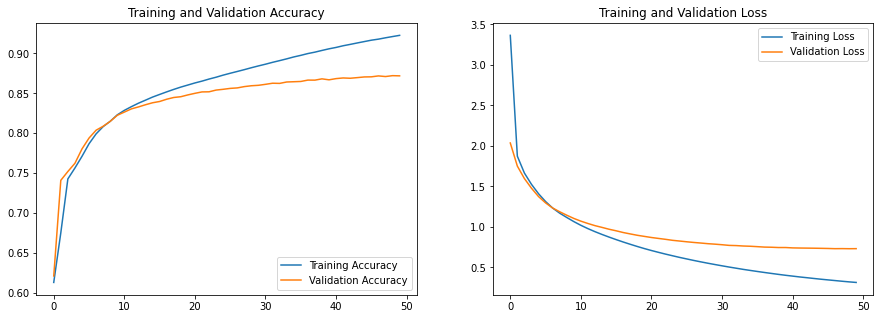

In [30]:
hist_plot(trans_hist)

### Step 6. 모델 평가하기

In [31]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # 에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = fra2idx['\t']

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # 에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [32]:
## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
##  인코더
## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 인코더 모델의 경우 기존에 정의를 재사용
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          289024    
_________________________________________________________________
masking (Masking)            (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  [(None, 64), (None, 64),  33024     
Total params: 322,048
Trainable params: 322,048
Non-trainable params: 0
_________________________________________________________________


In [34]:
## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
##  디코더
## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 이전 time step 에서의 …
## … hidden state를 저장하는 텐서 …
decoder_state_input_h = Input(shape=(hidden_units,))
## … cell state를 저장하는 텐서 …
decoder_state_input_c = Input(shape=(hidden_units,))
## …를 묶어서 하나의 변수로
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

## 테스트 단계에서는 디코더를 매 시점 별로 컨트롤 할 예정으로, 이를 위해서
## 이전 시점의 상태를 저장할 텐서인 
## decoder_state_input_h, decoder_state_input_c 를 정의.
## 매 시점 별로 디코더를 컨트롤하는 함수는 
## 뒤에서 정의할 decode_sequence() 를 살펴보아야 한다.


## 훈련 때 사용했던 임베딩 층을 재사용
decoder_embed_layer2 = decoder_embed_layer(decoder_inputs)

## 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
## → decoder_states_inputs 을 현재 time step의 초기 상태로 사용.
## （구체적인 동작 자체는 def decode_sequence()에 구현.）
decoder_outputs2, state_h2, state_c2 = \
    decoder_lstm(decoder_embed_layer2, initial_state=decoder_states_inputs)

## 현재 time step의 hidden state 와 cell state를 하나의 변수에 저장
decoder_states2 = [state_h2, state_c2]



## ──────────────────────────────────
##  디코더의 출력층 재설계
## ──────────────────────────────────

## 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

## 수정된 디코더
decoder_model = \
    Model(inputs=[decoder_inputs] + decoder_states_inputs,
          outputs=[decoder_outputs2] + decoder_states2)

decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     506048      input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 64)]         0                                            
____________________________________________________________________________________________

In [35]:
eng2idx = tokenizer_eng.word_index
idx2eng = tokenizer_eng.index_word
fra2idx = tokenizer_fra.word_index
idx2fra = tokenizer_fra.index_word

In [36]:
def decode_sequence(input_seq):
    
    ## ① 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
    ## 이 두개의 값을 ② states_value 에 할당
    states_value = encoder_model.predict(input_seq)

    ## ③ 디코더의 초기 입력으로 <sos>에 해당하는 정수 생성
    ## 이를 ④ target_seq 에 할당
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = fra2idx["<sos>"]    ## <sos>에 해당하는 정수
    
    ## while 루프에 사용
    stop_condition = False
    
    ## 반환값이 될 변수. 일단 빈 문자열로 지정.
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    while not stop_condition:
       
        ## ※ 중요
        ## ②, ④ 두개의 값을 디코더의 입력으로 사용
        ## 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        ## ⑤ output_tokens：현 시점의 예측 벡터
        ## ⑥ h：현시점의 은닉 상태
        ## ⑦ c：현시점의 셀 상태
        output_tokens, h, c = \
            decoder_model.predict([target_seq] + states_value)

        ## 아래에서는
        ## ⑤ output_tokens 의 예측 벡터로부터, 
        ## 현재 시점의 예측 단어인 ④ target_seq 를 얻는다.
        ## 그리고…
        ## ⑥ h：현시점의 은닉 상태, ⑦ c：현시점의 셀 상태 를 통해
        ## 현재시점의 ② states_value 를 만들어
        ## 다음 루프(시점)의 디코더 모델의 입력으로 사용할 것이다.
        
        ## 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = idx2fra[sampled_token_index]

        ## 도중 <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_word == "<eos>"):
            stop_condition = True
            break
        
        ## 현재 시점의 예측 단어를 예측 문장에 추가.
        ## 각 시점마다 번역된 단어는
        ## ⑧ decoded_sentence 에 누적하여 저장하였다가
        ## 루프를 빠져 나오면, 「최종 번역 시퀀스 값」으로 리턴된다.
        decoded_sentence += " " + sampled_word

        ## 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        ## 여기의 ④ target_seq 는, 다음 루프 시점의 디코더에 입력으로 사용될 것이다

        ## 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        ## ⑥ h：현시점의 은닉 상태, ⑦ c：현시점의 셀 상태 는
        states_value = [h, c]
        ## 다시 ② states_value 에 할당되어, 
        ## 바로 위의 ④ target_seq 와 함께, 
        ## 다음 루프 시점의 디코더에 입력으로 사용된다.

    return decoded_sentence.strip()

In [37]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_eng(input_seq):
    sentence = ""
    for encoded_word in input_seq:
        if(encoded_word != 0):
            sentence = sentence + idx2eng[encoded_word] + " "
    return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_fra(input_seq):
    sentence = ""
    for encoded_word in input_seq:
        if(encoded_word != 0 and 
           encoded_word != fra2idx["<sos>"] and 
           encoded_word != fra2idx["<eos>"]):
            sentence = sentence + idx2fra[encoded_word] + " "
    return sentence

In [39]:
for seq_index in np.random.randint(30000, size=5):
    input_seq = encoder_input_train[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("seq_index :", seq_index)
    print("입력문장 :", seq_to_eng(encoder_input_train[seq_index]))
    print("정답문장 :", seq_to_fra(decoder_input_train[seq_index]))
    print("번역문장 :", decoded_sentence)
    print("─" * 64)

seq_index : 7091
입력문장 : he lost his job . 
정답문장 : il perdit son travail . 
번역문장 : il a perdu son emploi .
────────────────────────────────────────────────────────────────
seq_index : 23410
입력문장 : how s school ? 
정답문장 : comment ca se passe a l ecole ? 
번역문장 : comment le temps il se trouve ?
────────────────────────────────────────────────────────────────
seq_index : 3552
입력문장 : we know it works . 
정답문장 : nous savons que cela fonctionne . 
번역문장 : nous le savons en francais .
────────────────────────────────────────────────────────────────
seq_index : 10038
입력문장 : i like your shoes . 
정답문장 : j aime tes souliers . 
번역문장 : j aime tes chaussures .
────────────────────────────────────────────────────────────────
seq_index : 11765
입력문장 : tom refused to go . 
정답문장 : tom refusa d y aller . 
번역문장 : tom refusa d aller .
────────────────────────────────────────────────────────────────


7091 : 그는 직장을 잃었다 / 그는 직장을 잃었다 / 그는 직장을 잃었다.   
23410 : 학교는 어때 / 학교에서 어떻게 지내니 / 날씨가 어때   
3552 : 우리는 그것이 작동한다는 것을 압니다. / 우리는 그것이 작동한다는 것을 압니다. / 우리는 그것을 프랑스어로 알고 있습니다.   
10038 : 네 신발 맘에 들어요. / 네 구두가 마음에 들어 / 네 구두가 마음에 든다   
11765 : 톰은 가기를 거부했습니다. / 탐은 그 곳에 가지 않았다 / 탐은 가기를 거부했습니다.   

In [41]:
for seq_index in np.random.randint(3000, size=5):
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("seq_index :", seq_index)
    print("입력문장 :", seq_to_eng(encoder_input_test[seq_index]))
    print("정답문장 :", seq_to_fra(decoder_input_test[seq_index]))
    print("번역문장 :", decoded_sentence)
    print("─" * 64)

seq_index : 1438
입력문장 : i want to be heard . 
정답문장 : je veux etre entendu . 
번역문장 : je veux etre de la chance .
────────────────────────────────────────────────────────────────
seq_index : 1977
입력문장 : silence please . 
정답문장 : silence s il vous plait . 
번역문장 : veuillez etre prudente .
────────────────────────────────────────────────────────────────
seq_index : 1706
입력문장 : study harder . 
정답문장 : etudie davantage . 
번역문장 : etudiez davantage .
────────────────────────────────────────────────────────────────
seq_index : 2745
입력문장 : you re very rude . 
정답문장 : vous etes fort grossieres . 
번역문장 : tu es tres grossier .
────────────────────────────────────────────────────────────────
seq_index : 2495
입력문장 : record this . 
정답문장 : enregistre ceci . 
번역문장 : enregistrez ceci .
────────────────────────────────────────────────────────────────


1438 : 저는 듣고 싶습니다. / 듣고 싶어요. / 저는 운이 좋기를 바랍니다.   
1977 : 조용히 해 주세요. / 조용히 해 주세요 / 부디 몸조심하세요   
1706 : 더욱 열심히 공부하다. / 무슨 일이 일어나고 있다. / 자, 더 공부해라   
2745 : 당신은 매우 무례합니다. / 당신은 매우 무례하시군요. / 너 정말 무례하구나.   
2495 : 이것을 기록합니다. / 이것을 기록하세요. / 이것을 기록하세요.